In [1]:
""" stacked LSTM """

# import libraries
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data_hr - data_hr2.csv', encoding='utf-8')

In [3]:
data = data[26280:]
data = data.reset_index(drop=True, inplace=False)
data = data.fillna(0)

In [4]:
print(data)

                    date  dam(t-1)   90  100  101  211  212
0        2000-01-01 1:00   148.600  0.0  0.0  0.0  0.0  0.0
1        2000-01-01 2:00     0.000  0.0  0.0  0.0  0.0  0.0
2        2000-01-01 3:00   143.400  0.7  0.0  0.0  0.0  0.0
3        2000-01-01 4:00     0.000  0.0  0.0  0.0  0.0  0.0
4        2000-01-01 5:00     0.000  0.0  0.0  0.0  0.0  0.0
...                  ...       ...  ...  ...  ...  ...  ...
210379  2023-12-31 20:00     0.000  0.0  0.0  0.0  0.0  0.0
210380  2023-12-31 21:00   124.118  0.0  0.0  0.0  0.0  0.0
210381  2023-12-31 22:00    15.417  0.0  0.0  0.0  0.0  0.0
210382  2023-12-31 23:00     0.000  0.0  0.0  0.0  0.0  0.0
210383   2024-01-01 0:00   148.222  0.0  0.0  0.0  1.7  0.3

[210384 rows x 7 columns]


In [5]:
# save original 'Open' prices for later
original_dam = data['dam(t-1)'].values

In [6]:
# separate dates for future plotting
dates = pd.to_datetime(data['date'])

In [7]:
# variables for training
cols = list(data)[1:7]

In [8]:
print(cols)

['dam(t-1)', '90', '100', '101', '211', '212']


In [9]:
# new dataframe with only training data - 5 columns
data = data[cols].astype(float)

In [10]:
# # normalize the dataset
# scaler = StandardScaler()
# scaler = scaler.fit(data)
# dam_data_scaled = scaler.transform(data)

# dam = data.drop(['90','100','101','211','212'], axis=1)

# scaler_dam = StandardScaler()
# dam_scaled = scaler_dam.fit_transform(dam)

In [11]:
scaler = MinMaxScaler()
dam_data_scaled = scaler.fit_transform(data)

dam = data.drop(['90','100','101','211','212'], axis=1)
scaler_dam = MinMaxScaler()
dam_scaled = scaler_dam.fit_transform(dam)

In [12]:
print(dam_data_scaled[:25])

[[0.0140256  0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.0135348  0.00789177 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.00631435 0.         0.00148588 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.0076263  0.         0.         0.         0.         0.        ]
 [0.         0.         0.00148588 0.         0.         0.        ]
 [0.0013969  0.         0.         0.         0.         0.        ]
 [0.00756023 0.         0.         0.         0.         0.        ]
 [0.         0.         0.00594354 0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.         0.00450958 0.00445765

In [13]:
# split to train data and test data
n_train = int(0.9*dam_data_scaled.shape[0])
train_data_scaled = dam_data_scaled[0: n_train]
train_dates = dates[0: n_train]

test_data_scaled = dam_data_scaled[n_train:]
test_dates = dates[n_train:]
print(test_dates.head(5))

189345   2021-08-07 10:00:00
189346   2021-08-07 11:00:00
189347   2021-08-07 12:00:00
189348   2021-08-07 13:00:00
189349   2021-08-07 14:00:00
Name: date, dtype: datetime64[ns]


In [14]:
print(train_data_scaled[23:26])

[[0.00846633 0.0011274  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.        ]
 [0.00665414 0.         0.         0.         0.         0.        ]]


In [15]:
# data reformatting for LSTM
pred_days = 1  # prediction period
seq_len = 24   # sequence length = past days for future prediction.
input_dim = 5  # input_dimension = ['90', '100', '101', '211', '212']

trainX = []
trainY = []
testX = []
testY = []

for i in range(seq_len, n_train-pred_days +1):
    trainX.append(train_data_scaled[i - seq_len:i, 1:train_data_scaled.shape[1]])
    trainY.append(train_data_scaled[i + pred_days - 2:i + pred_days-1, 0])

for i in range(seq_len, len(test_data_scaled)-pred_days +1):
    testX.append(test_data_scaled[i - seq_len:i, 1:test_data_scaled.shape[1]])
    testY.append(test_data_scaled[i + pred_days - 2:i + pred_days-1, 0])

trainX, trainY = np.array(trainX), np.array(trainY)
testX, testY = np.array(testX), np.array(testY)

In [16]:
print(trainY[1], trainX[1])

[0.] [[0.         0.         0.         0.         0.        ]
 [0.00789177 0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00148588 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00148588 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00594354 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.00450958 0.00445765 0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.00148588 0.         0.         0.        ]
 [0.     

In [17]:
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(189321, 24, 5) (189321, 1)
(21015, 24, 5) (21015, 1)


In [18]:
# LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(trainX.shape[1], trainX.shape[2]), # (seq length, input dimension)
               return_sequences=True))
model.add(LSTM(32, return_sequences=False))
model.add(Dense(trainY.shape[1]))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 64)            17920     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [19]:
# specify your learning rate
learning_rate = 0.01
# create an Adam optimizer with the specified learning rate
optimizer = Adam(learning_rate=learning_rate)
# compile your model using the custom optimizer
model.compile(optimizer=optimizer, loss='mse')

In [32]:
# Try to load weights
try:
    model.load_weights('hr_dam_lstm_nodam_weights.h5')
    print("Loaded model weights from disk")
except:
    print("No weights found, training model from scratch")
    # Fit the model
    history = model.fit(trainX, trainY, epochs=30, batch_size=32,
                    validation_split=0.1, verbose=1)
    # Save model weights after training
    model.save_weights('hr_dam_lstm_nodam_weights.h5')

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.legend()
    plt.show()

Loaded model weights from disk


In [21]:
# # generate array filled with means for prediction
# mean_values_pred = np.repeat(scaler.mean_[np.newaxis, :], prediction.shape[0], axis=0)

# # substitute predictions into the first column
# mean_values_pred[:, 0] = np.squeeze(prediction)

# # inverse transform
# y_pred = scaler.inverse_transform(mean_values_pred)[:,0]

# # generate array filled with means for testY
# mean_values_testY = np.repeat(scaler.mean_[np.newaxis, :], testY.shape[0], axis=0)

# # substitute testY into the first column
# mean_values_testY[:, 0] = np.squeeze(testY)

# # inverse transform
# testY_original = scaler.inverse_transform(mean_values_testY)[:,0]
# print(testY_original.shape)

657/657 [==============================] - 2s 3ms/step
(21015, 1) (21015, 1)


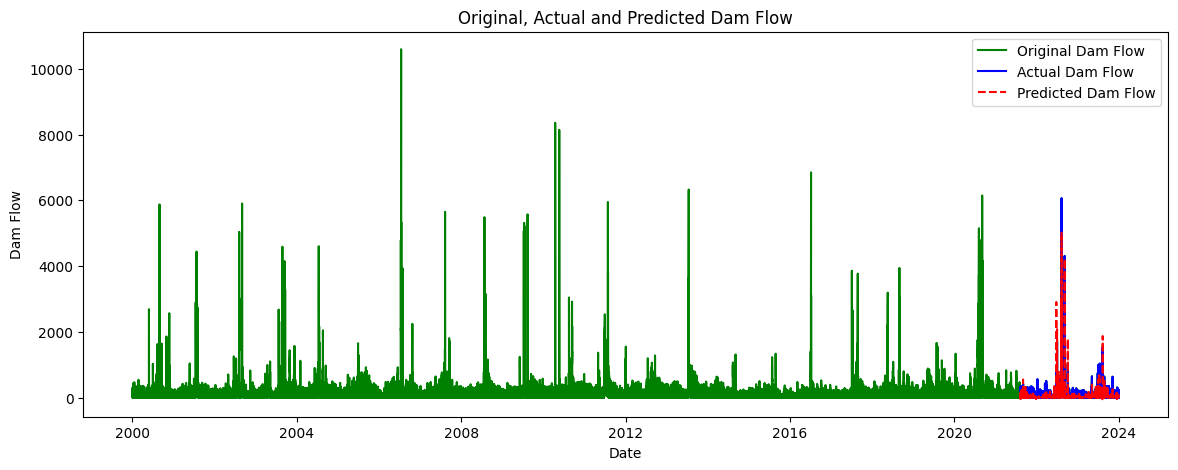

In [33]:
# prediction
prediction = model.predict(testX)
print(prediction.shape, testY.shape)

y_pred = scaler_dam.inverse_transform(prediction)[:,0]
testY_original = scaler_dam.inverse_transform(testY)[:,0]

# plotting
plt.figure(figsize=(14, 5))

# plot original
plt.plot(dates, original_dam, color='green', label='Original Dam Flow')

# plot actual vs predicted
plt.plot(test_dates[seq_len:], testY_original, color='blue', label='Actual Dam Flow')
plt.plot(test_dates[seq_len:], y_pred, color='red', linestyle='--', label='Predicted Dam Flow')
plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Original, Actual and Predicted Dam Flow')
plt.legend()
plt.show()

In [23]:
print(test_dates)

189345   2021-08-07 10:00:00
189346   2021-08-07 11:00:00
189347   2021-08-07 12:00:00
189348   2021-08-07 13:00:00
189349   2021-08-07 14:00:00
                 ...        
210379   2023-12-31 20:00:00
210380   2023-12-31 21:00:00
210381   2023-12-31 22:00:00
210382   2023-12-31 23:00:00
210383   2024-01-01 00:00:00
Name: date, Length: 21039, dtype: datetime64[ns]


In [24]:
testDates = pd.DataFrame(test_dates[24:])
testDates = testDates.reset_index(drop = True)
pred_y = pd.DataFrame(y_pred)
origin_y = pd.DataFrame(testY_original)

lstm_include_dam = pd.concat([testDates, origin_y, pred_y], axis = 1)
print(lstm_include_dam)

lstm_include_dam = pd.DataFrame(lstm_include_dam)
lstm_include_dam.to_csv("data/hr_lstm_notinclude_dam.csv")

                     date        0          0
0     2021-08-08 10:00:00    0.500   5.315891
1     2021-08-08 11:00:00   68.522   5.969096
2     2021-08-08 12:00:00   71.548   3.926822
3     2021-08-08 13:00:00    0.000   7.488726
4     2021-08-08 14:00:00   71.713   4.754409
...                   ...      ...        ...
21010 2023-12-31 20:00:00  173.106   5.298769
21011 2023-12-31 21:00:00    0.000   6.474167
21012 2023-12-31 22:00:00  124.118  13.017489
21013 2023-12-31 23:00:00   15.417  13.156640
21014 2024-01-01 00:00:00    0.000   8.313137

[21015 rows x 3 columns]


In [25]:
testX_last = []

for x in testX:
  testX_last.append(x[-1])

print(testX_last[0])

testX_last = scaler_dam.inverse_transform(testX_last)
testX_last = pd.DataFrame(testX_last)

lstm_notinclude_x = pd.concat([testDates, testX_last, origin_y, pred_y], axis = 1)
lstm_notinclude_x.to_csv("data/hr_lstm_notinclude_x.csv")

print(lstm_notinclude_x)

[0.00225479 0.         0.         0.         0.        ]
                     date           0    1    2    3    4        0          0
0     2021-08-08 10:00:00   23.889317  0.0  0.0  0.0  0.0    0.500   5.315891
1     2021-08-08 11:00:00    0.000000  0.0  0.0  0.0  0.0   68.522   5.969096
2     2021-08-08 12:00:00    0.000000  0.0  0.0  0.0  0.0   71.548   3.926822
3     2021-08-08 13:00:00  274.727143  0.0  0.0  0.0  0.0    0.000   7.488726
4     2021-08-08 14:00:00   23.889317  0.0  0.0  0.0  0.0   71.713   4.754409
...                   ...         ...  ...  ...  ...  ...      ...        ...
21010 2023-12-31 20:00:00    0.000000  0.0  0.0  0.0  0.0  173.106   5.298769
21011 2023-12-31 21:00:00    0.000000  0.0  0.0  0.0  0.0    0.000   6.474167
21012 2023-12-31 22:00:00    0.000000  0.0  0.0  0.0  0.0  124.118  13.017489
21013 2023-12-31 23:00:00    0.000000  0.0  0.0  0.0  0.0   15.417  13.156640
21014 2024-01-01 00:00:00    0.000000  0.0  0.0  0.0  0.0    0.000   8.313137

[21015

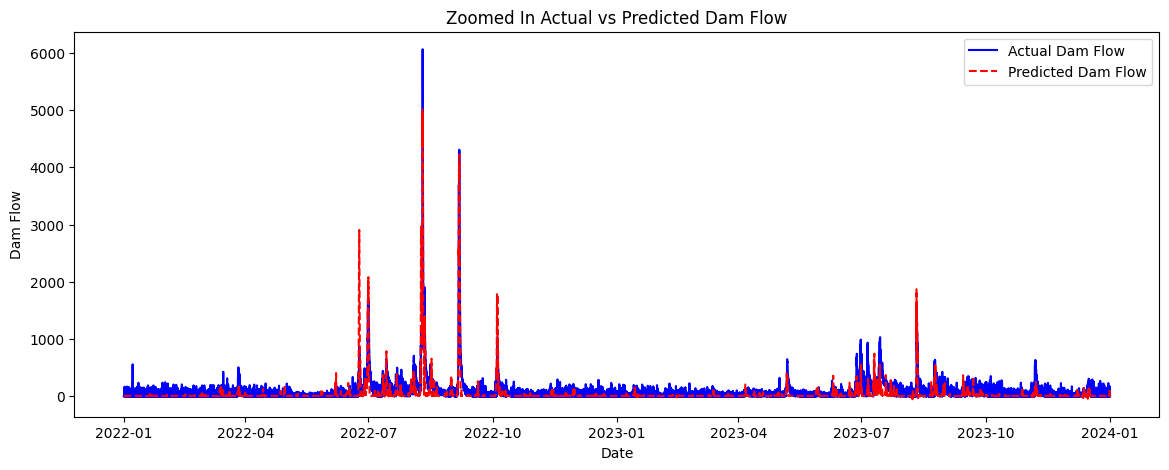

In [41]:
# Calculate the start and end indices for the zoomed plot
zoom_start = len(test_dates) - 24*365*2
zoom_end = len(test_dates)

# Create the zoomed plot
plt.figure(figsize=(14, 5))

# Adjust the start index for the testY_original and y_pred arrays
adjusted_start = zoom_start - seq_len

plt.plot(test_dates[zoom_start:zoom_end],
         testY_original[adjusted_start:zoom_end - zoom_start + adjusted_start],
         color='blue',
         label='Actual Dam Flow')

plt.plot(test_dates[zoom_start:zoom_end],
         y_pred[adjusted_start:zoom_end - zoom_start + adjusted_start ],
         color='red',
         linestyle='--',
         label='Predicted Dam Flow')

plt.xlabel('Date')
plt.ylabel('Dam Flow')
plt.title('Zoomed In Actual vs Predicted Dam Flow')
plt.legend()
plt.show()

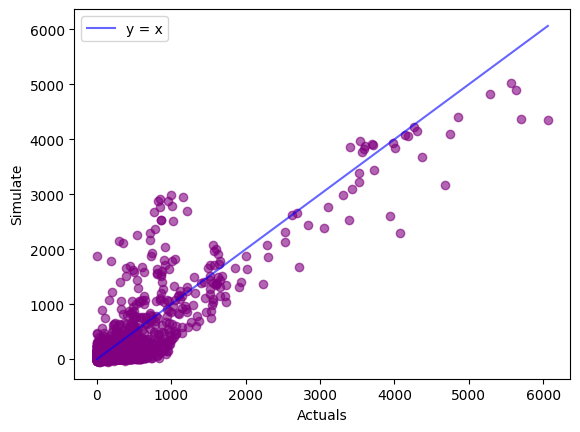

In [27]:
# 일대일 그래프
x = np.arange(0,max(max(testY_original), max(y_pred)))
y = x
plt.scatter(testY_original[:], y_pred[:], color = 'purple', alpha = 0.6)
plt.plot(x,y, color = 'blue', alpha = 0.6, label = 'y = x')
plt.xlabel('Actuals')
plt.ylabel('Simulate')

plt.legend()
plt.show()

In [34]:
#RMSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(testY_original, y_pred))
print('RMSE : %.2f' %(rmse))

RMSE : 122.08


In [35]:
# NSE
from numpy import mean
num_sum1 = 0
num_sum2 = 0
num_avg = mean(testY_original[:])
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1**2
  num2 = testY_original[i] - num_avg
  num_sum2 += num2**2

nse = 1 - (num_sum1 / num_sum2)
print('NSE : %f' %nse)

NSE : 0.679030


In [36]:
# PBIAS
num_sum1 = 0
for i in range(len(testY_original)):
  num1 = testY_original[i] - y_pred[i]
  num_sum1 += num1

pbias = (num_sum1 / np.sum(testY_original[:])) * 100
print('PBIAS : %f' %pbias)

PBIAS : 52.547884


In [37]:
#R^2
import math

num_sum1 = 0
num_sum2 = 0
num_sum3 = 0
act_avg = mean(testY_original[:])
pred_avg = mean(y_pred[:])
for i in range(len(testY_original)):
  num1 = (testY_original[i] - act_avg) * (y_pred[i] - pred_avg)
  num_sum1 += num1
  num2 = testY_original[i] - pred_avg
  num_sum2 += num2**2
  num3 = y_pred[i] - pred_avg
  num_sum3 += num3**2

r_square = (num_sum1 / (math.sqrt(num_sum2)* math.sqrt(num_sum3)))**2
print('R Square : %f' %r_square)

R Square : 0.699693
